# Exploration 10. 뉴스기사 요약해보기

## Step 1. 데이터 수집하기

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data.sample(10)

,headlines,text
63595,"Shahid has shaant zen-like vibe, easy to work ...","Actor Ranveer Singh, while talking about his '..."
36720,"Sonali, Tabu told Salman to shoot blackbuck, s...",Actresses Sonali Bendre and Tabu told Salman t...
49034,Don't dump junk on us: SC to govt on incomplet...,Slamming the Centre over an 845-page affidavit...
84634,CBI denies delay in sending evidence against M...,The CBI has said there was no delay in forward...
87971,Ford replaces CEO Mark Fields as shares plunge,Ford Motor has announced it was replacing CEO ...
75416,16-year-old who cannot vote running for Kansas...,A 16-year-old student is running as a Democrat...
51696,Paytm Payments Bank starts physical debit card...,Paytm Payments Bank Savings Account holders ca...
40774,Peace is a two way street: Kaif on Afridi's an...,Reacting to former Pakistan captain Shahid Afr...
93789,Bihar medicos to pay Ã¢ÂÂ¹15L for quitting PG...,The Nitish Kumar-led Bihar Cabinet has decided...
3534,Third woman enters Sabarimala temple amid prot...,"Kerala Police have confirmed that Sasikala, a ..."


In [4]:
data.columns=['Summary', 'Text']
data.head(1)

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  98401 non-null  object
 1   Text     98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


## Step 2. 데이터 전처리하기 (추상적 요약)

### 2.1 중복 샘플 

중복된 데이터를 확인하고 데이터프레임의 drop_duplicates()를 사용해서 중복 샘플 제거 

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2.2 결측 샘플 

결측값이 있을 경우 dropna() 함수를 사용해서 제거 

In [8]:
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


### 2.3 텍스트 정규화 

`it'll`과 `it will` `mustn't`과 `must not` 같은 표현은 같은 표현이기 때문에 다른 단어로 간주해서 연산량을 늘리는 것보다 기계 학습 전 미리 같은 표현으로 통일시키면 기계의 연산량을 줄일 수 있음

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 2.4 불용어 제거

일반적으로 텍스트에 자주 등장하지만 자연어 처리 할 때, 도움이 되지 단어들을 제거하는 것이 때로는 자연어 처리의 성능을 높일 수 있음

Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 2.5 데이터 전처리 함수 

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [13]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

178.29139137268066  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

정제 과정에서 문장의 모든 단어가 사라지는 경우도 존재하기 때문에 empty 샘플이 존재하는지 확인 

In [14]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

Summary    0
Text       0
dtype: int64

### 2.6 훈련 데이터와 테스트 데이터 나누기 

#### 2.6.1 샘플의 최대 길이 정하기 



텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


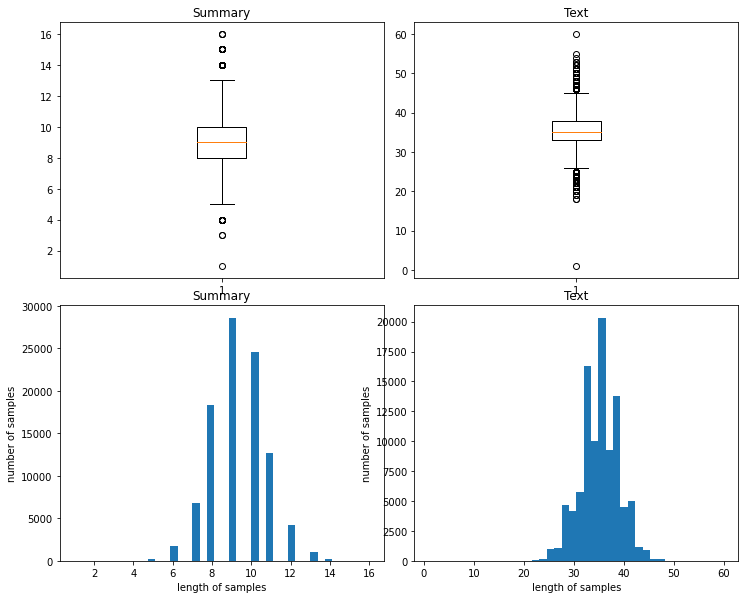

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(2,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.subplot(2,2,3)
plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(2,2,4)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 경우 최소길이 1, 최대 길이 60이고 평균길이 35로 시각화된 그래프로 봤을때, 대체적으로 40 내외의 길이를 가짐 

Summary의 경우 최소길이 1, 최대길이 15이고 평균길이 9.2로 시각화된 그래프를 봤을 때, 대체적으로 12이하의 길이를 가지고 있음

In [16]:
text_max_len = 40
summary_max_len = 12

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


각각의 길이를 40, 12로 정했을 때, 각각의 데이터의 92%, 98%를 포함함

#### 2.6.2 시작 토큰과 종료 토큰 추가하기 

In [18]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 2.6.3 훈련 데이터와 테스트 데이터 분리 

In [20]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[43626 37874 28891 ... 11785 22279  6190]


In [21]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [22]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [23]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 2.7 정수 인코딩

In [24]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [25]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69536
등장 빈도가 6번 이하인 희귀 단어의 수: 47394
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22142
단어 집합에서 희귀 단어의 비율: 68.1575011504832
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.490184219056432


등장 빈도가 6회 이하인 단어들은 단어 집합에서 68%를 차지하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 3.4%로 비교적 적음

등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 제외하고 훈련 데이터에서 제거하기 위해 `단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합 크기`를 어림잡아 20,000으로 제한

In [26]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

`texts_to_sequences()`를 사용하여 생성된 단어 집합에 기반해 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩 수행

In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[66, 689, 38, 2088, 1961, 2101, 854, 185, 75, 113, 1372, 2515, 1894, 161, 60, 966, 219, 148, 75, 231, 3791, 2244, 17488, 3960, 326, 30, 1, 38, 768, 2088, 457, 673, 473, 326, 310, 1, 3792, 622], [181, 11, 381, 183, 3468, 374, 3327, 10252, 12964, 1, 637, 1305, 2813, 10, 307, 6631, 1629, 93, 5702, 122, 1412, 2, 6, 2960, 12964, 1, 208, 348, 842, 3092, 878, 32, 1619, 2021, 3917, 250, 8400], [256, 273, 1026, 9666, 212, 887, 823, 128, 972, 183, 274, 1026, 54, 4581, 7162, 6, 256, 1276, 84, 212, 414, 887, 823, 128, 5870, 274, 1026, 256, 816, 879, 823, 273, 1026, 101, 3596, 183, 816, 1495, 27, 143, 41]]


Summary 데이터에 대해서도 동일한 작업 수행

In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30090
등장 빈도가 5번 이하인 희귀 단어의 수: 19673
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10417
단어 집합에서 희귀 단어의 비율: 65.3805250913925
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.643808912796723


등장 빈도가 5회 이하인 단어들은 단어 집합에서 65%를 차지하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 4.6%로 비교적 적음

등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 제외하고 훈련 데이터에서 제거하기 위해 `단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합 크기`를 어림잡아 10,000으로 제한

In [29]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 76, 236, 20, 9, 1077, 3247, 211, 1298, 4270, 4, 25], [1, 4002, 595, 61, 910, 4, 8, 94, 1407], [1, 258, 911, 2154, 372, 131, 1437, 128, 94, 194, 911], [1, 253, 1078, 1676, 1725, 590], [1, 59, 10, 47, 3391, 153, 72, 1702]]
target
decoder  [[76, 236, 20, 9, 1077, 3247, 211, 1298, 4270, 4, 25, 2], [4002, 595, 61, 910, 4, 8, 94, 1407, 2], [258, 911, 2154, 372, 131, 1437, 128, 94, 194, 911, 2], [253, 1078, 1676, 1725, 590, 2], [59, 10, 47, 3391, 153, 72, 1702, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있음

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와 길이가 0이지만 토큰이 추가되어 길이가 1인 인덱스를 확인

In [30]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


### 2.8 패딩하기

서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업 진행

최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춤

In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

### 3.1 API를 이용한 인코더 설계

In [32]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 3.2 디코더 설계

In [33]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 3.3 Attention 을 사용한 디코더 출력층 설계

In [34]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [35]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3.4 모델 훈련

'조기 종료'를 뜻하는 `EarlyStopping`은 특정 조건이 충족되면 훈련을 멈춤

In [36]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 216s 667ms/step - loss: 6.0144 - val_loss: 5.2132
Epoch 2/50
308/308 [==============================] - 206s 669ms/step - loss: 5.1655 - val_loss: 4.8399
Epoch 3/50
308/308 [==============================] - 202s 656ms/step - loss: 4.7648 - val_loss: 4.5573
Epoch 4/50
308/308 [==============================] - 202s 657ms/step - loss: 4.4795 - val_loss: 4.3720
Epoch 5/50
308/308 [==============================] - 200s 649ms/step - loss: 4.2556 - val_loss: 4.2279
Epoch 6/50
308/308 [==============================] - 201s 652ms/step - loss: 4.0772 - val_loss: 4.1080
Epoch 7/50
308/308 [==============================] - 200s 650ms/step - loss: 3.9140 - val_loss: 4.0159
Epoch 8/50
308/308 [==============================] - 200s 650ms/step - loss: 3.7821 - val_loss: 3.9323
Epoch 9/50
308/308 [==============================] - 201s 654ms/step - loss: 3.6635 - val_loss: 3.8718
Epoch 10/50
308/308 [==============================] - 201s 653m

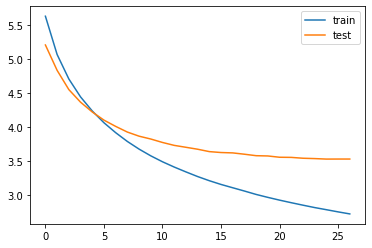

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 4.1 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전 미리 준비

In [38]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [39]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [40]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [41]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 4.2 모델 테스트하기

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수로 패딩을 위해 사용되는 숫자0, Summary의 정수 시퀀스의 숫자 0, 시작토큰 인덱스, 종료 토큰 인덱스를 출력에서 제외 

In [42]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [43]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : rolex wristwatch owned late actor paul newman fetched million auction making expensive wristwatch ever auctioned sold times expected wristwatch gift newman wife gifted watch daughter boyfriend auctioned 
실제 요약 : costliest to be auctioned sells for crore 
예측 요약 :  cake with cr for auction


원문 : kid sized submarine offered billionaire elon musk help evacuate teenage footballers trapped thailand cave practical mission rescue mission head said tuesday musk visited cave left pod built spacex rocket parts case may useful future ten boys already rescued 
실제 요약 : elon musk pod not for this mission thai cave 
예측 요약 :  musk to rescue kids with thai cave rescue kids


원문 : microsoft fired director sports marketing alliances jeff allegedly tried million company also accused stealing selling football game tickets meant microsoft employees broker charged sending two fraudulent invoices company 
실제 요약 : microsoft fires exec who allegedly tried to mn 
예측 요약 :  microsoft exec accused of stealing 

## Step 5. Summa을 이용해서 추출적 요약해보기

In [74]:
import requests
from summa.summarizer import summarize

In [75]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
summa_data.columns=['Summary', 'Text']

In [78]:
summa_data.drop_duplicates(subset = ['Text'], inplace=True)

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z.!?]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(summa_data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(summa_data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(summa_data['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

summa_data['Text'] = clean_text

정규화 사전의 수:  120
215.9956076145172  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience. program upgrad degree career support helped transition data scientist tech mahindra salary hike. upgrad online power learning powered lakh careers.'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year. pranav kaushik delhi techie bagged reward spending cred coins. users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult.fit more.'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series. india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history.'
 ...
 'according reports new version science fiction film matrix development. michael jordan reportedly play le

원문의 50%로 요약

In [80]:
for i in range(50, 100):
    print("원문 :",  summa_data['Text'][i])
    print("실제 요약 :", summa_data['Summary'][i])
    print("예측 요약 :", summarize(summa_data['Text'][i], words=20))
    print("\n")

원문 : former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said. comes media report tuesday accused dhfl controlling shareholders diverting funds shell companies buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said.


원문 : us based boeing wednesday reported annual sales worth billion first time planemaker sales crossed billion mark year history. company said expects deliver commercial aircraft boeing retained position world largest planemaker seventh straight year delivering aircraft
실제 요약 : Boeing sales cross $100bn for 1st time in its 102-yr history
예측 요약 : us based boeing wednesday reported annual sales worth billion f

단어수 20개로 요약

In [81]:
for i in range(50, 100):
    print("원문 :", summa_data['Text'][i])
    print("실제 요약 :", summa_data['Summary'][i])
    print("예측 요약 :", summarize(summa_data['Text'][i],ratio=0.5))
    print("\n")

원문 : former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said. comes media report tuesday accused dhfl controlling shareholders diverting funds shell companies buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said.


원문 : us based boeing wednesday reported annual sales worth billion first time planemaker sales crossed billion mark year history. company said expects deliver commercial aircraft boeing retained position world largest planemaker seventh straight year delivering aircraft
실제 요약 : Boeing sales cross $100bn for 1st time in its 102-yr history
예측 요약 : us based boeing wednesday reported annual sales worth billion f

전처리 과정을 넣었더니 문장의 앞부분만 잘라오는 느낌이라 전처리 없이 다시 진행

In [82]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
summa_data.columns=['Summary', 'Text']

In [83]:
for i in range(50, 100):
    print("원문 :",  summa_data['Text'][i])
    print("실제 요약 :", summa_data['Summary'][i])
    print("예측 요약 :", summarize(summa_data['Text'][i], words=20))
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

In [84]:
for i in range(50, 100):
    print("원문 :", summa_data['Text'][i])
    print("실제 요약 :", summa_data['Summary'][i])
    print("예측 요약 :", summarize(summa_data['Text'][i],ratio=0.5))
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

훨씬 요약같은 (?) 느낌이 강해졌다. 

추상적 요약과 추출적 요약 문법 부분은 맞지 않는 모습을 보인다. 

하지만 두가지 모두 단어로 뜻을 유추하면 요약이 생각했던 것 보다는 잘 되는 것 같다. 아마도 핵심단어를 뽑아내는 부분에서는 두 요약법 모두 좋은 것 같다. 

추출적 요약에서 놀랐던 점은 문법은 맞지 않아도 원문 내용에서 하고자하는 말이 정말 간단한 과정으로 잘 나온다는 점이다. 

추상적요약은 원문에 원인과 결과가 있다면 둘중에 하나만 요약하는 경향이 있는 것 같다! 



## 회고 

텍스트 처리에 대한 익스를 여러번 진행하면서 처음엔 보기도 힘들었던 텍스트 처리가 이젠 볼 수 있게 되었다. 참 다행이다. 

눈에 딱 보이는 이미지 처리만 매력있다고 생각했는데 텍스트 처리도 그만의 매력이 있는 것 같다. 

점점 모델을 세팅하는 것도 눈에 익어가고 외계어 같던 정규식도 옆집 아저씨같다.

앞으로 더 친해졌으면 좋겠다. 